# Image Reduction Module

**Lecturer:** Anupama Gadiyara<br>
**Jupyter Notebook Author:** Kishalay De & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Winter School 2018.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-astro-school-2018-resources.html

## Objective
Process raw images from a visible wavelength telescope and make them ready for photometric analysis

## Key steps
- Reduce raw images by applying biases & flats
- Mask cosmic rays
- Align consecutive images

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* astroscrappy
* pyregion

### External packages
* SWarp https://www.astromatic.net/software
* SExtractor https://www.astromatic.net/software

In [3]:
#import some useful modules 
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import os
from astropy.stats import sigma_clipped_stats
import numpy as np
import subprocess
import astroscrappy
import pyregion
import shutil

## Test dependencies

In order for this jupyter notebook to function correctly, we must have some external software installed, as described above.  The following step assures that these are installed properly before getting to the rest of the content of this lesson.

In [2]:
dependencies = ['SWarp', 'sextractor']

def test_dependency(dep):
    try:
        subprocess.Popen(dep, stderr=subprocess.PIPE).stderr.read()
        print("%s is installed properly. OK" % dep)
        return 1
    except ImportError:
        print("===%s IS NOT YET INSTALLED PROPERLY===" % dep)
        return 0
        
i = 0
for dep in dependencies:
    i += test_dependency(dep)
print("\n%i out of %i dependencies installed properly." % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing.")
else:
    print("You are ready to continue.")

FileNotFoundError: [WinError 2] The system cannot find the file specified

## Define where data live

The various directories where data live are defined here for use later in this notebook

In [3]:
curpath = os.path.abspath('.')                  # top level directory
dataFolder = os.path.join(curpath, 'data')      # data dir
biasFolder = os.path.join(dataFolder, 'bias')   # biases
flatFolder = os.path.join(dataFolder, 'flats')  # flats
sciFolder = os.path.join(dataFolder, 'science') # science data
procFolder = os.path.join(curpath, 'processing')# processing directory
if not os.path.isdir(procFolder): 
    os.mkdir(procFolder)
else:
    for f in os.listdir(procFolder):
        os.remove(os.path.join(procFolder,f)) #clear the processing folder from previous iterations

In [4]:
os.chdir(sciFolder)
fileList = glob.glob('*.fits')
os.chdir(curpath)
procList = [os.path.join(procFolder, file) for file in fileList]
sciList = [os.path.join(sciFolder, file) for file in fileList]

## Data description
The image data received from the telescope is in the form of a FITS file containing a 2D array of counts that represent the brightness distribution on the sky as seen by the detector. We have to remove the effects of the telescope optical chain from this image to get the true brightness distribution on the sky. There are are a few different steps involved here. We will call this image distribution $I(x,y)$ as a function of x, y coordinates.

-  Bias correction: The detector image comes with an electronic offset introduced by the voltages applied to the the semiconductor-based detector. We have to first remove this offset to get real counts received by the detector. Let's call this offset $B(x,y)$. Thw way to measure these offsets is to record images with zero exposure time, so that the recorded image reflects the intrinsic offsets in the detector (since the detector does not receive any photons if the exposure time is zero).

## Creating a bias frame

We'll start this module by creating a master bias frame to be subtracted from each of the science and flat images. The idea is to use a median combination of multiple bias frames to get rid of transient features like cosmic rays in each of the individual bias frames, and create a 'Master bias' frame.

Found 3 bias files


<Figure size 576x576 with 0 Axes>

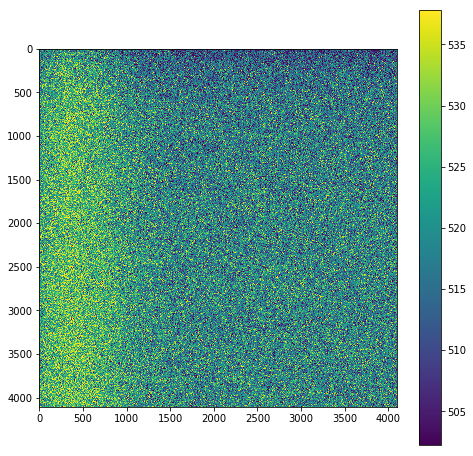

In [5]:
biasList = glob.glob(os.path.join(biasFolder,'*fits'))

numBiasFiles = len(biasList)
print('Found %d bias files'%numBiasFiles)

#Let's load all the files into a numpy array
#This is a 3D array with each element representing a 4096 x 4108 pixel array corresponding to each input image
biasImages = np.zeros((4108, 4096, numBiasFiles))

for i in range(numBiasFiles):
        biasImages[:,:,i] = fits.open(biasList[i])[0].data

#Let's plot up a single bias frame
plt.figure(figsize=(8,8))
mean, median, std = sigma_clipped_stats(biasImages[:,:,0])
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(biasImages[:,:,0], vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.show()

#Now creating the master bias frame by doing a median combination for each pixel in the list of images
masterBias = np.median(biasImages, axis=2)

Now plot the master bias frame and check what it looks like

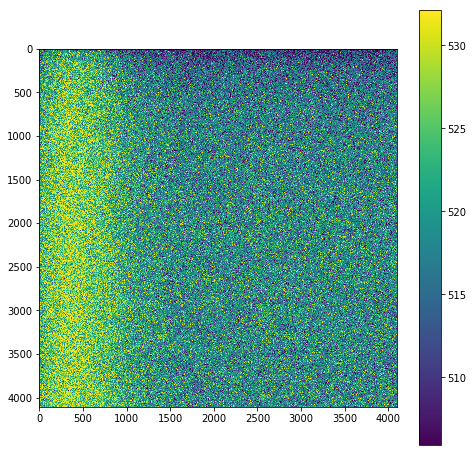

In [6]:
#Lets plot the bias image
mean, median, std = sigma_clipped_stats(masterBias)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(masterBias, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.show()

- Flat fielding: The image recorded on the detector is a multplication of the true brightness distribution on the sky and the response of the telescope optics + detector in different parts of the image. We combine all of these effects into a single calibration frame called the flat frame. In order to measure the response of the instrument, we expose the detector to a uniform light source -- this can either be a uniformly illuminated part of the telescope dome or just sky frames taken during twilight (the assumption is that the sky is uniformly bright over a small field of view). Let's call this instrument response as $F(x,y)$.

## Creating a flat frame

Now, we'll do the same thing for the flat images. First, subtract the master bias from each of the flat frames to remove the detector offsets, and then do a median combination of all the frames to produce a master flat image (again, to get rid of transient artifacts). We will also normalize each frame before combining to remove effects due to time varying illumination from the flat field, and to conserve counts in the reduced images.

Found 3 flat files


<Figure size 576x576 with 0 Axes>

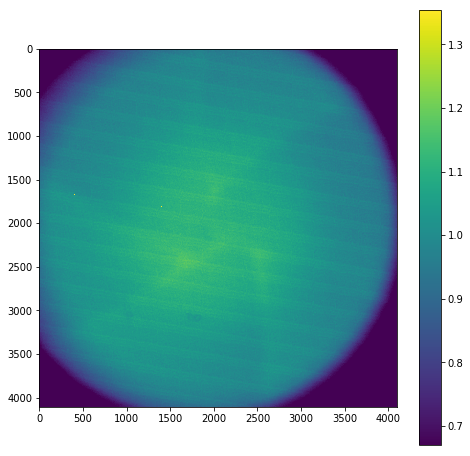

In [7]:
flatList = glob.glob(os.path.join(flatFolder, '*fits'))

numFlatFiles = len(flatList)
print('Found %d flat files'%numFlatFiles)

#Load the images into an array, as in the case of the bias frames
flatImages = np.zeros((4108, 4096, numFlatFiles))

for i in range(numFlatFiles):
        #subtract the master bias and store the flat field image
        flatImages[:,:,i] = fits.open(flatList[i])[0].data - masterBias
        flatImages[:,:,i] = flatImages[:,:,i] / np.median(flatImages[:,:,i])
        
        
#Let's plot up a single flat frame
plt.figure(figsize=(8,8))
mean, median, std = sigma_clipped_stats(flatImages[:,:,0])
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(flatImages[:,:,0], vmin = median - 5*std, vmax = median + 5*std)
plt.colorbar()
plt.show()

As in the case of the bias frames, we have the flat field images loaded into an array, and have to combine them to get a master flat. Perform a median combination on the flat field images and plot the master flat produced.

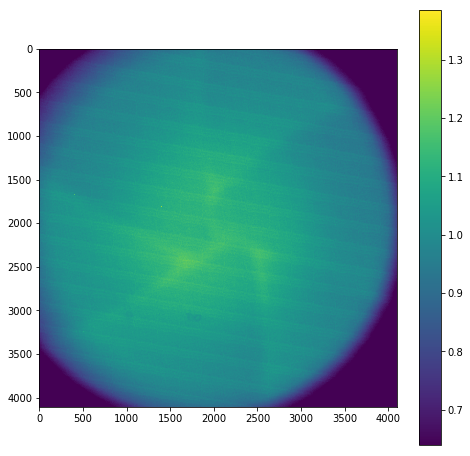

In [8]:
masterFlat = np.mean(flatImages, axis = 2)

mean, median, std = sigma_clipped_stats(masterFlat)
plt.figure(figsize=(8,8))
#scale the image according to its statistics
plt.imshow(masterFlat, vmin = median - 5*std, vmax = median + 5*std)
plt.colorbar()
plt.show()

At this point, we have the necessary calibration images to reduce science images and visualize the true brightness distribution on the sky. Let the true brightness distribution on the sky be $S(x,y)$, then the image $I(x,y)$ can be expressed as:

## \begin{equation}
I(x,y) = F(x,y) \,  S(x,y) + B(x,y)
\end{equation}

So, we now have to retrieve $S(x,y)$ from $I(x,y)$.

## Pre-processing science frames
Now, we will apply the bias flat calibrations to the science frames and write pre-processed science frames to disk for further processing.

But first, let's plot a raw image and see what it looks like.


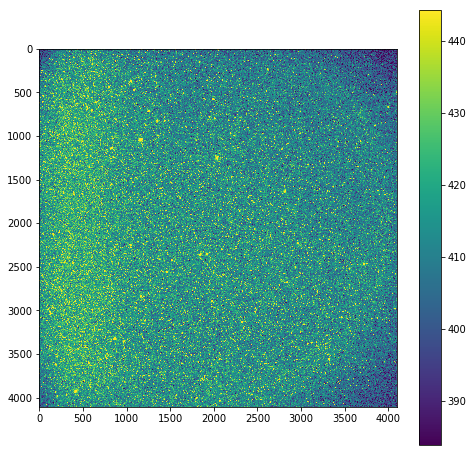

In [9]:
#Plot the first raw image here
rawHDU = fits.open(sciList[0])[0]
rawData = rawHDU.data
plt.figure(figsize = (8,8))
mean, median, std = sigma_clipped_stats(rawData)
plt.imshow(rawData, vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()
plt.show()

In [10]:
#Now let's apply the bias and flat calibrations to all the science frames.
#And save them to the "processing" directory
numSciFiles = len(sciList)
print('Found %d science files'%numSciFiles)

for i in range(numSciFiles):
        rawHDU = fits.open(sciList[i])[0]
        rawData = rawHDU.data
        rawHeader = rawHDU.header
        #Correct for the bias and flats here
        procData = (rawData - masterBias) / masterFlat
        procHDU = fits.PrimaryHDU(procData)
        procHDU.header = rawHeader
        procHDU.header.remove('BZERO')
        procHDU.header.remove('BSCALE')
        #Write the reduced frame to disk, propagating the original header of the raw image
        procHDU.writeto(procList[i]+'.proc.fits', overwrite=True)

Found 4 science files


Now loop through the processed science images we just wrote to the disk and plot them to see what they look like.

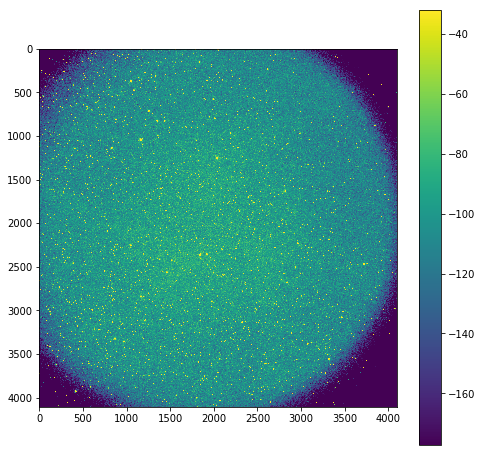

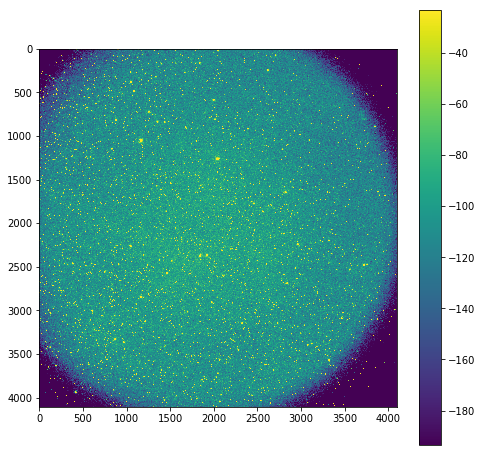

In [11]:
for i in range(2):
        procHDU = fits.open(procList[i]+'.proc.fits')[0]
        procData = procHDU.data
        plt.figure(figsize = (8,8))
        mean, median, std = sigma_clipped_stats(procData)
        plt.imshow(procData, vmin = median - 3*std, vmax = median + 3*std)
        plt.colorbar()
        plt.show()

-  Images from CCD detectors are often affected by artifacts from cosmic rays. Cosmic rays are high energy particles streaming through space that can hit a detector during the observation and produce streak-like patterns in the detector. Open up the reduced images in ds9. Do you see any artifacts that look like bright streaks?

In order to remove these artifacts, we will use a python implementation of a popular code known as lacosmic (originally written by Pieter van Dokkum, and modified by Curtis McCully) that looks for sharp changes in the intensity distribution on the image. Recall that a real astrophysical source is always blurred by atmospheric seeing in the image (they have smooth Gaussian profiles), so that sharp point-like / streak-like artifacts are a good indicator of cosmic-rays.

We also need a few operating parameters for the detector (that describe it's intrinsci noise) in order to peform the cosmic ray removal.

In [12]:
detectorGain = 1.6 #in e-/ADU
readNoise = 14.0 #in electrons
saturLevel = 150000 #in electrons
#Need to verify these numbers for GROWTH India telescope

#Load in one reduced image
procHDU = fits.open(procList[0]+'.proc.fits')[0]
procData = procHDU.data
procHeader = procHDU.header

crmask, cleanArray = astroscrappy.detect_cosmics(procData,gain=detectorGain,readnoise=readNoise, satlevel=saturLevel)

#crmask is the mask of pixels that appear to be affected by a cosmic ray and cleanArray is the cleaned image after cosmic ray removal
print('Number of affected pixels is %d for file %s'%(np.sum(crmask), sciList[0])) 
#print number of affected pixels

#The returned clean array is in units of electrons -- have to divide it by the gain to recover ADUs
procData_cr = cleanArray / detectorGain
crCleanHDU = fits.PrimaryHDU(procData_cr)
crCleanHDU.header = procHeader
#Write the cleaned image to disk
crCleanHDU.writeto(procList[0] +'.proc.cr.fits', overwrite=True)

Number of affected pixels is 386521 for file /home/chummels/new_version/image_reduction/data/science/C0_20181013-183430-709.wcs.fits


Plot the array crmask to see the affected pixels that were picked out by the cosmic ray flagging routine

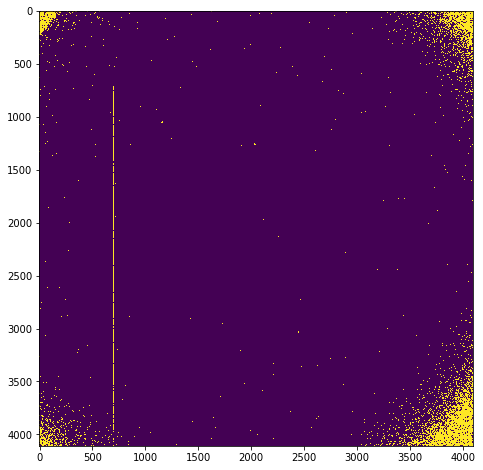

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(crmask)
plt.show()

Now do the cosmic ray cleaning for the rest of the files

In [14]:
for i in range(1, numSciFiles):
        procHDU = fits.open(procList[i]+'.proc.fits')[0]
        procData = procHDU.data
        procHeader = procHDU.header
        
        crmask, cleanArray = astroscrappy.detect_cosmics(procData,gain=detectorGain,readnoise=readNoise, satlevel=saturLevel)

        print('Number of affected pixels is %d for file %s'%(np.sum(crmask), sciList[i])) #print number of affected pixels

        #The returned clean array is in units of electrons -- have to divide it by the gain to recover ADUs
        procData_cr = cleanArray / detectorGain
        crCleanHDU = fits.PrimaryHDU(procData_cr)
        crCleanHDU.header = procHeader
        crCleanHDU.writeto(procList[i] +'.proc.cr.fits', overwrite=True)

Number of affected pixels is 397325 for file /home/chummels/new_version/image_reduction/data/science/C0_20181013-190734-760.wcs.fits
Number of affected pixels is 400662 for file /home/chummels/new_version/image_reduction/data/science/C0_20181013-201128-360.wcs.fits
Number of affected pixels is 400721 for file /home/chummels/new_version/image_reduction/data/science/C0_20181013-174714-557.wcs.fits


-  We now have some real reduced images that reflect the true brightness distribution on the sky. The next step is to derive the scale and orientation of the pixels in the image with respect to the sky, also known as astrometric calibration

## Performing astrometric calibration

We will now solve the astrometry for the image. There are a number of popular packages available on the internet for computing astrometry from images. Notable examples include astrometry.net, which is capable of solving the astrometry of images without knowing the location of the image at all (can take a long time to get a good match though) and scamp, which is a part of the Astromatic suite of software and takes in an input list of known catalog stars to solve for the image astrometry using an inital guess.

The purpose of this module is to understand how astrometry works in general. So, we will be using a relatively simple to understand code developed by Daniel Perley at LJMU (and a GROWTH partner) called autoastrometry. The idea behind the code is to first detect stars in a given image using a code known as SExtractor (we will learn more about SExtractor in the photometry module). It also downloads a list of known stars within the field using an initial estimate for the position of the image (that is usually available from the telescope pointing information).

Internally, for each star in the observed image, the code calulates the offsets and orientations of the stars to all of its neighbors, and does the same for every star in the catalog image. It then compares the orientation and distances of each of these matched pairs in the real image and the catalog, and saves similar 'good' matches for further inspection. Finally, it checks for stars that have a large number of good matches and saves them as a secure 'asterism'. This allows it to finally compute the pixel scale and orientation of the image from the average of all the good matched stars after rejecting outliers.

Let's have a look at how the code runs, and check it's outputs.

In [15]:
#Dan Perley's astrometry python code
autoastrometry_script = os.path.join(dataFolder, 'autoastrometry.py')
os.chdir(procFolder)

try:
    #Run the autoastrometry script using 2MASS as the reference catalog by specifying 'tmc' with the '-c' option
    filenames = os.path.join(procList[0])+'.proc.cr.fits'
    command = 'python %s %s -c tmc' % (autoastrometry_script, filenames)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run autoastrometry with error %s. Check if file exists.'%err)

#Keep an eye on the terminal to check the matches found by auto-astrometry

Executing command: python /home/chummels/new_version/image_reduction/data/autoastrometry.py /home/chummels/new_version/image_reduction/processing/C0_20181013-183430-709.wcs.fits.proc.cr.fits -c tmc


Let's look at the asterism matches found by autoastrometry by plotting the image with the matches. Note that the output file from autoastrometry has 'a' appended to the file name in the beginning.

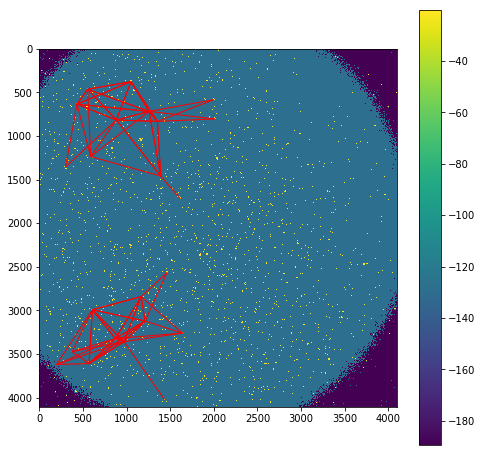

In [16]:
#Name of the region file containing the matched asterisms
region_name = 'matchlines.im.reg'
r = pyregion.open(region_name)
#Loading the matched asterisms for plotting
patch_list, artist_list = r.get_mpl_patches_texts()

fig, ax = plt.subplots(1, figsize=(8,8))
procData = fits.open(procList[0]+'.proc.cr.fits')[0].data
mean, median, std = sigma_clipped_stats(procData)
plt.imshow(procData, vmin = median - 3*std, vmax = median + 3*std)

#overlay the asterisms on the plot
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)

plt.colorbar()
plt.show()

Now, run autoastrometry on all of the reduced images. All of the solved files will have an 'a' appended to their names at the beginning.


In [17]:
for i in range(1, numSciFiles):
    try:
        filelist = procList[i]+'.proc.cr.fits'
        command = 'python %s %s -c tmc' % (autoastrometry_script, filelist)
        print('Executing command: %s' % command)
        rval = subprocess.run(command.split(), check=True)
    except subprocess.CalledProcessError as err:
        print('Could not run autoastrometry with error %s. Check if file exists.'%err)

Executing command: python /home/chummels/new_version/image_reduction/data/autoastrometry.py /home/chummels/new_version/image_reduction/processing/C0_20181013-190734-760.wcs.fits.proc.cr.fits -c tmc
Executing command: python /home/chummels/new_version/image_reduction/data/autoastrometry.py /home/chummels/new_version/image_reduction/processing/C0_20181013-201128-360.wcs.fits.proc.cr.fits -c tmc
Executing command: python /home/chummels/new_version/image_reduction/data/autoastrometry.py /home/chummels/new_version/image_reduction/processing/C0_20181013-174714-557.wcs.fits.proc.cr.fits -c tmc


So far, we have obtained reduced images from raw images, derived their position and orientation in the sky by matching star patterns to a known catalog of objects and in principle, are ready to go to the next step, which is derive real physical brightnesses for objects in the image (that we will do in the Photometry module).

However, we are often interested in stacking a number of images together to get a deeper image than what is possible in a single image. Recall that the noise in Gaussian variable goes down as $\sqrt{N}$ when you average $N$ images together, so that stacking can be really useful when you are limited by short exposures. For instance, this is very common in near-infrared imaging, where we are forced to take short exposures because the sky is very bright and would saturate the detector for long exposures. 

## Stacking science images

Here, we will use a code called Swarp, that is again a part of the Astromatic suite of software to stack the four images of this field into a deeper image. Swarp takes each input image, and uses the known image position to resample them on to a common output grid. These resampled images are then combined (usually with a median) into a final deeper image. Resampling involves taking the counts in one image and projecting them onto a different output grid (which need not be the same scale or orientaion as the original image), by interpolating between pixels of the input image and filling up the output grid with the interpolated values. Let's see how swarp runs on these images.

The important part of running swarp is to feed the correct parameters to it's configuration file for stacking the images. For now, we have a configuration file ready to be used.

In [18]:
swarpConfigFile = os.path.join(dataFolder, 'stack.swarp')

#Make a text file listing the images to be stacked to feed into swarp
swarpFileList = os.path.join(procFolder, 'swarpFileList.txt')
f = open(swarpFileList, 'w')
for i in range(numSciFiles):
    f.write(os.path.join(procFolder, 'a'+fileList[i]+'.proc.cr.fits\n'))
f.close()

try:
    #IMAGEOUT_NAME is the output stackd file, WEIGHTOUT_NAME is the output weight file, RESAMPLE_DIR is the directory where the resampled images are to be stored
    command = 'SWarp -c %s @%s -IMAGEOUT_NAME V641Cyg_g_stack.fits -WEIGHTOUT_NAME V641Cyg_g_stack.weight.fits -RESAMPLE_DIR %s' % (swarpConfigFile, swarpFileList, procFolder)
    print("Executing command: %s" % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run swarp. Can you run it from the terminal?')
print(os.getcwd())

Executing command: SWarp -c /home/chummels/new_version/image_reduction/data/stack.swarp @/home/chummels/new_version/image_reduction/processing/swarpFileList.txt -IMAGEOUT_NAME V641Cyg_g_stack.fits -WEIGHTOUT_NAME V641Cyg_g_stack.weight.fits -RESAMPLE_DIR /home/chummels/new_version/image_reduction/processing
/home/chummels/new_version/image_reduction/processing


Check the terminal to see the output of swarp. Swarp first resamples all of the images onto a common output grid that is aligned to the north (this behavior can be changed by playing with the configuration file). Let's plot the resampled images produced by swarp.

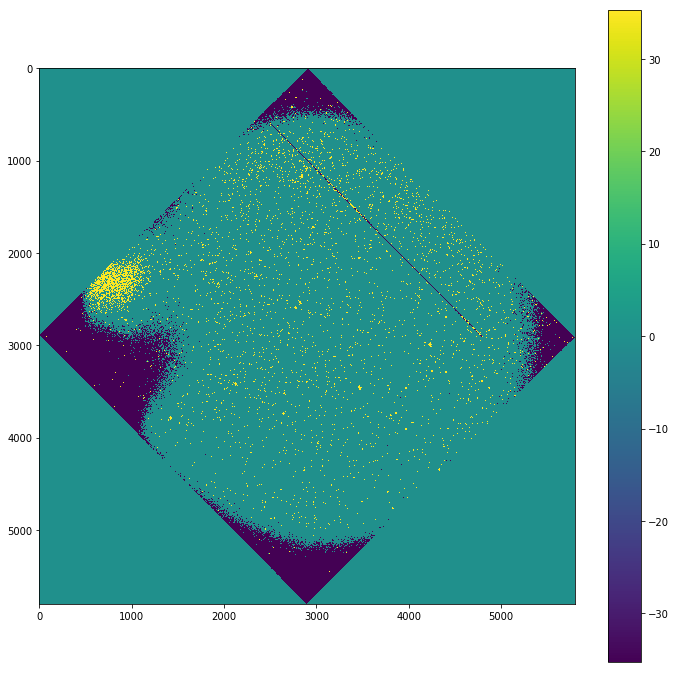

In [19]:
for i in range(1):
    resampFileName = os.path.join(procFolder, 'a'+fileList[i]+'.proc.cr.resamp.fits')
    resampHDU = fits.open(resampFileName)[0]
    resampData = resampHDU.data
    
    plt.figure(figsize=(12,12))
    mean, median, std = sigma_clipped_stats(resampData)
    plt.imshow(resampData, vmin = median - 3*std, vmax = median + 3*std)
    plt.colorbar()
    plt.show()

Note how the images are rotated because swarp resampled the image on to a grid that is aligned to the north whereas the input images were not. The stacked image has been written to the file V641Cyg_g_stack.fits. Now, plot the image and check it visually

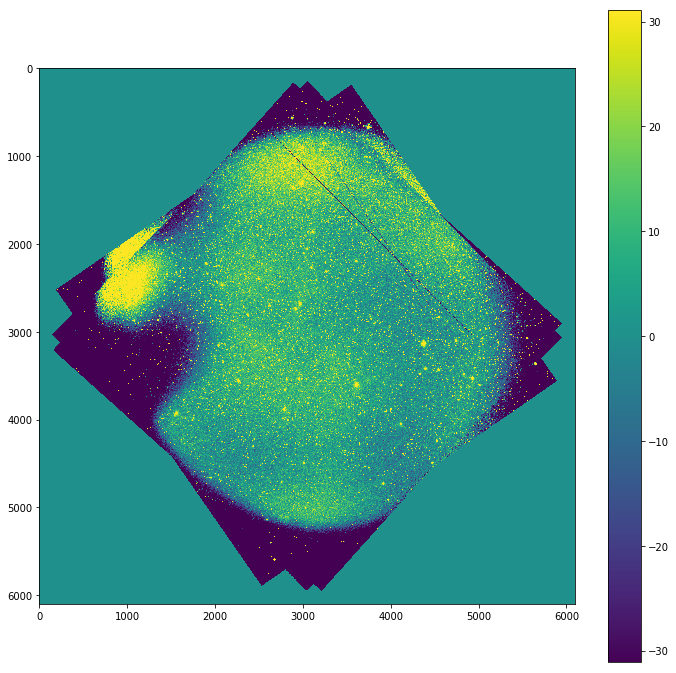

In [20]:
stackHDU = fits.open('V641Cyg_g_stack.fits')[0]
stackData = stackHDU.data

plt.figure(figsize=(12,12))
mean, median, std = sigma_clipped_stats(stackData)
plt.imshow(stackData, vmin = median - 3*std, vmax = median + 3*std)
plt.colorbar()
plt.show()

Note how the outer circular edges of the image are darkened -- this is because the images were rotated with respect to each other. You can try opening this image in ds9 to see zoom in to see individual stars.

### We now have a deep stacked science image that is ready for performing photometry, which is the subject of the next module.

In the effort to not bog down your hard drive too much.  You can execute the next cell to remove all of the processed data that we just produced, something on the order of 3 GB.

In [21]:
# WARNING: WILL REMOVE YOUR PROCESSED DATA FROM THIS NOTEBOOK
os.chdir(curpath)
shutil.rmtree(procFolder)